# Generalization with OOP: The MeanRevBacktester Class

## Using the Bollinger Class to backtest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

In [31]:
class Bollinger():
    ''' Class for the vectorized backtesting of Bollinger Bands-based trading strategies.
    '''
    
    def __init__(self, ticker, SMA, gap, start, end, trading_cost):
        '''
        Parameters
        ----------
        ticker: str
            ticker ticker (instrument) to be backtested
        SMA: int
            moving window in bars (e.g. days) for SMA
        gap: int
            distance for Lower/Upper Bands in Standard gapiation units
        start: str
            start date for data import
        end: str
            end date for data import
        trading_cost: float
            proportional transaction/trading costs per trade
        '''
        self.ticker = ticker
        self.SMA = SMA
        self.gap = gap
        self.start = start
        self.end = end
        self.trading_cost = trading_cost
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return f"Bollinger(ticker = {self.ticker}, SMA = {self.SMA}, gap = {self.gap}, start = {self.start}, end = {self.end})"

    def get_data(self):
        ''' Imports the data from specified source 
        '''
        raw_data = pd.read_csv("../csv_files_example/forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw_data = raw_data[self.ticker].to_frame().dropna()
        raw_data = raw_data.loc[self.start:self.end]
        raw_data.rename(columns={self.ticker: "price"}, inplace=True)
        raw_data["returns"] = np.log(raw_data / raw_data.shift(1))
        self.data = raw_data
        
    def prepare_data(self):
        '''Prepares the data for Bollinger-based strategy backtesting .
        '''
        data = self.data.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.gap
        data["Upper"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.gap
        self.data = data
        
    def set_parameters(self, SMA = None, gap = None):
        ''' Updates parameters (SMA, gap) and the prepared dataset
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.gap
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.gap
            
        if gap is not None:
            self.gap = gap
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.gap
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.gap
            
    def test_strategy(self):
        ''' Backtests the Bollinger Bands-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.trading_cost
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA = {} | gap = {} | trading_cost = {}".format(self.ticker, self.SMA, self.gap, self.trading_cost)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))     
   
    def optimize_parameters(self, SMA_range, gap_range):
        ''' Finds the optimal strategy (global maximum) given the Bollinger Bands parameter ranges.

        Parameters
        ----------
        SMA_range, gap_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        combinations = list(product(range(*SMA_range), range(*gap_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA", "gap"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf


In [33]:
df = pd.read_csv("../csv_files_example/forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
df

,AUDEUR=X,EURUSD=X,USDGBP=X
Date,,,
2004-01-01,0.59780,1.258194,0.56016
2004-01-02,0.60314,1.258194,0.55751
2004-01-05,0.60467,1.268698,0.55334
2004-01-06,0.60350,1.272103,0.54906
2004-01-07,0.60728,1.264095,0.55012
...,...,...,...
2020-06-24,0.61349,1.131235,0.79841
2020-06-25,0.60938,1.125087,0.80561
2020-06-26,0.61373,1.122208,0.80480


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4295 entries, 2004-01-01 to 2020-06-30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AUDEUR=X  4274 non-null   float64
 1   EURUSD=X  4275 non-null   float64
 2   USDGBP=X  4287 non-null   float64
dtypes: float64(3)
memory usage: 134.2 KB


In [29]:
ptc = 0.00007

In [35]:
tester = Bollinger("EURUSD=X", 30, 2, "2018-01-01", "2019-12-31", ptc)

In [36]:
tester

Bollinger(ticker = EURUSD=X, SMA = 30, gap = 2, start = 2018-01-01, end = 2019-12-31)

In [37]:
tester.test_strategy()

(1.099713, 0.186043)

In [38]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2018-02-12,1.225280,-0.000650,1.223244,1.189579,1.256908,0.002036,0.0,-0.000000,0.0,0.999351,1.000000
2018-02-13,1.230376,0.004150,1.224218,1.191520,1.256915,0.006158,0.0,0.000000,0.0,1.003507,1.000000
2018-02-14,1.235376,0.004056,1.225185,1.192962,1.257409,0.010191,0.0,0.000000,0.0,1.007585,1.000000
2018-02-15,1.246727,0.009146,1.226708,1.194890,1.258526,0.020019,0.0,0.000000,0.0,1.016843,1.000000
2018-02-16,1.250360,0.002909,1.228157,1.196116,1.260198,0.022202,0.0,0.000000,0.0,1.019806,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1.109016,-0.000333,1.107637,1.098293,1.116981,0.001380,-1.0,0.000333,0.0,0.904525,1.110833
2019-12-26,1.109545,0.000477,1.107911,1.098855,1.116966,0.001635,-1.0,-0.000477,0.0,0.904956,1.110303
2019-12-27,1.110112,0.000510,1.108180,1.099368,1.116991,0.001932,-1.0,-0.000510,0.0,0.905418,1.109736


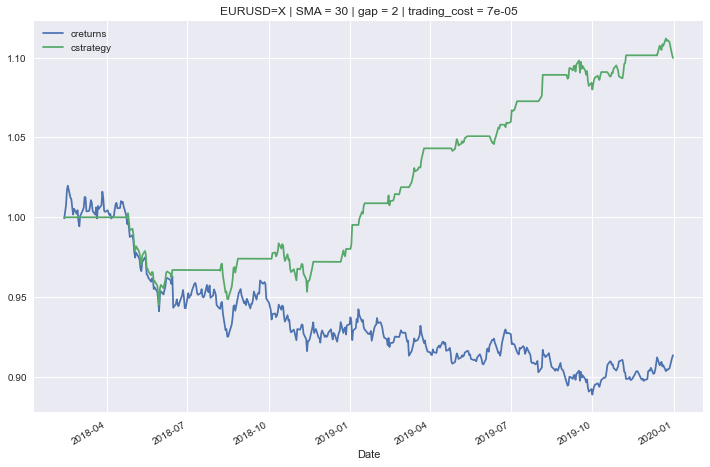

In [39]:
tester.plot_results()

In [40]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

((29, 1), 1.181918)

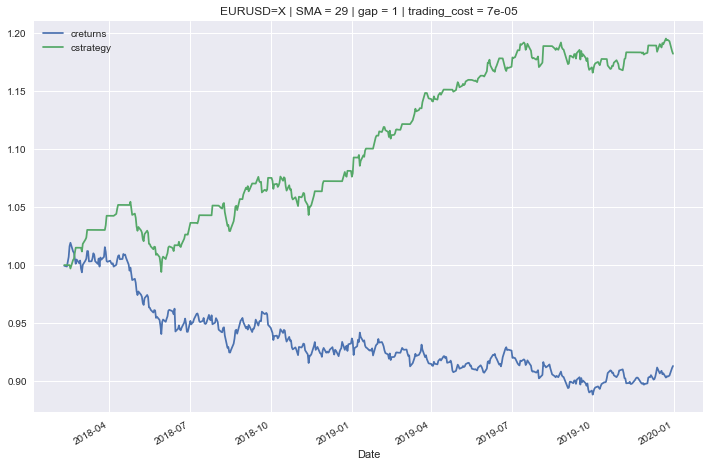

In [41]:
tester.plot_results()

In [42]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2018-02-09,1.226076,-0.000601,1.223173,1.206048,1.240299,0.002903,0.0,-0.000000,0.0,0.999399,1.000000
2018-02-12,1.225280,-0.000650,1.224005,1.207409,1.240601,0.001275,0.0,-0.000000,0.0,0.998750,1.000000
2018-02-13,1.230376,0.004150,1.224834,1.208554,1.241113,0.005542,0.0,0.000000,0.0,1.002904,1.000000
2018-02-14,1.235376,0.004056,1.226018,1.210291,1.241744,0.009359,0.0,0.000000,0.0,1.006980,1.000000
2018-02-15,1.246727,0.009146,1.227392,1.211656,1.243127,0.019336,-1.0,-0.000070,1.0,1.016232,0.999930
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1.109016,-0.000333,1.107854,1.103257,1.112452,0.001162,-1.0,0.000333,0.0,0.903981,1.193869
2019-12-26,1.109545,0.000477,1.108113,1.103645,1.112581,0.001433,-1.0,-0.000477,0.0,0.904413,1.193299
2019-12-27,1.110112,0.000510,1.108272,1.103818,1.112726,0.001840,-1.0,-0.000510,0.0,0.904874,1.192690


In [43]:
tester.results_overview

,SMA,gap,performance
0,25,1,1.170814
1,25,2,1.116929
2,25,3,1.015834
3,25,4,1.000000
4,26,1,1.166570
...,...,...,...
295,98,4,1.000000
296,99,1,1.062371
297,99,2,1.048060
298,99,3,1.013070


In [44]:
tester.results_overview.nlargest(10, "performance")

,SMA,gap,performance
16,29,1,1.181918
0,25,1,1.170814
28,32,1,1.168307
4,26,1,1.166570
24,31,1,1.162892
8,27,1,1.160177
12,28,1,1.153410
32,33,1,1.151356
40,35,1,1.150579
20,30,1,1.144025


In [45]:
tester.results_overview.nsmallest(10, "performance")

,SMA,gap,performance
154,63,3,0.971289
158,64,3,0.971289
162,65,3,0.971289
166,66,3,0.971289
170,67,3,0.971289
174,68,3,0.971289
178,69,3,0.971289
182,70,3,0.971289
186,71,3,0.971289
190,72,3,0.971289


__Backtesting & Forward Testing__

In [49]:
train = Bollinger("EURUSD=X", 30, 2, "2018-01-01", "2018-12-31", ptc)

In [50]:
train.optimize_parameters((25, 100, 1), (1, 5, 1)) # in-sample

((32, 1), 1.090664)

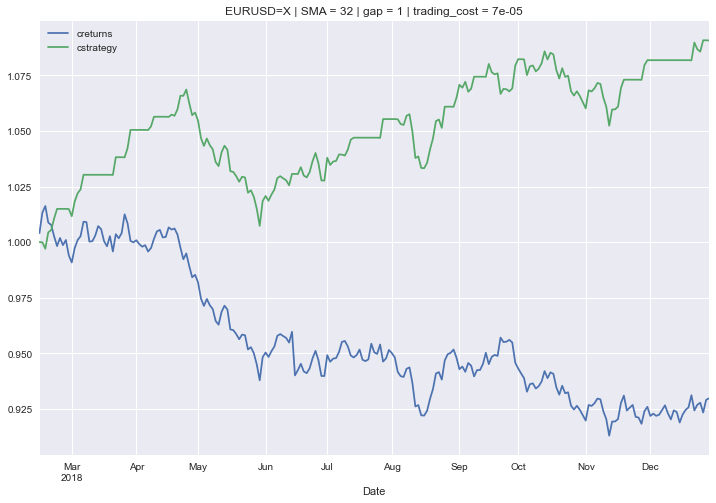

In [51]:
train.plot_results() # in-sample

In [52]:
tester = Bollinger("EURUSD=X", 74, 1, "2019-01-01", "2019-12-31", ptc) # out-sample

In [53]:
tester.test_strategy()

(1.027948, 0.033139)

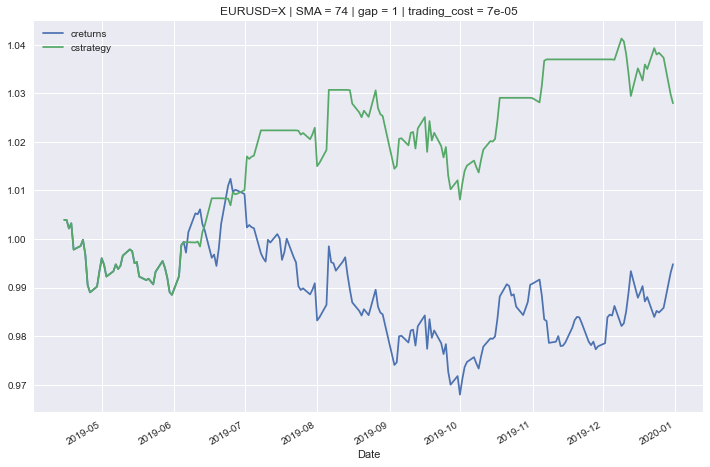

In [54]:
tester.plot_results()

__GBP/USD__

In [58]:
tester = Bollinger("USDGBP=X", 30, 2, "2018-01-01", "2019-12-31", 0)

In [59]:
tester.test_strategy()

(1.012805, -0.049875)

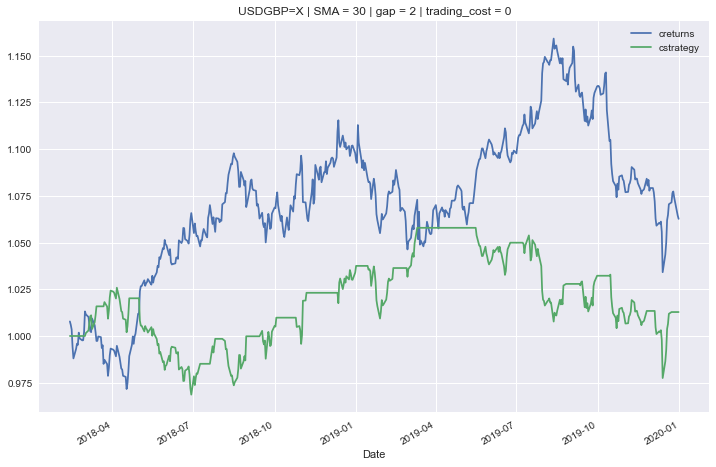

In [60]:
tester.plot_results()

In [61]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

((40, 3), 1.072839)

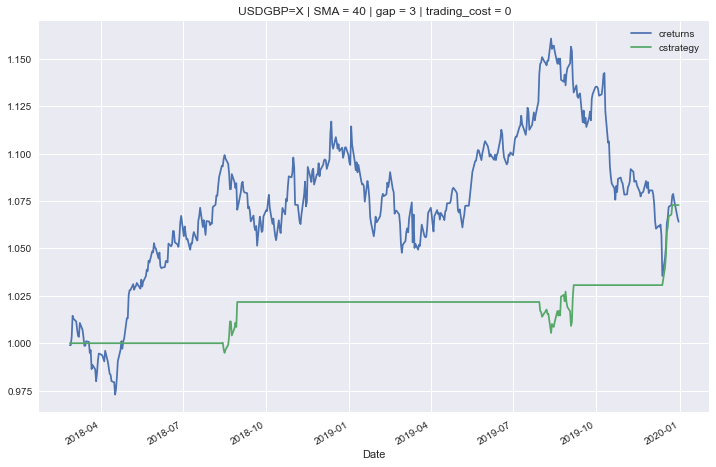

In [62]:
tester.plot_results()